In [1]:
import numpy as np
from src.db import engine
from sqlalchemy.orm import Session
from src.db.models import CalibrationRecording
import matplotlib.pyplot as plt
import src.api.controllers.generate_embeddings  as generate_embeddings
from pathlib import Path
from src.db.models import SimRoomClass
from src.api.controllers.calibration_recording_controller import recording_uuid_to_calibration_id, get_annotated_classes, AnnotatedClassResponse
from src.aliases import UInt8Array
import shutil

2025-04-06 21:16:59.864391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 21:17:00.040577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743967020.111247  269698 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743967020.131146  269698 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 21:17:00.298129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Creating Embeddings from Annotations for each Class:

Some important notes here:

We should probably be setting a minimum sample count per class when labeling. 
Additionally, we should set an upper bound on the number of samples per class added to the database, based on the lowest amount of samples available for the classes.

Question: Should we do data augmentation as well?

The following are some interesting parameters to experiment with based on experimentation on real-world data:
1. Sample count per class
2. Data augmentation (and which kinds?)
3. Same number of samples per class or not?
4. ?

In [ ]:
def get_annotated_samples(annotated_classes: list[AnnotatedClassResponse]) -> tuple[list[UInt8Array], list[int]]:
    X = []
    Y = []

    # Check if there are enough samples for each class
    for annotated_class in annotated_classes:        
        for annotation_path in annotated_class.annotation_paths:
            file = np.load(annotation_path)
            X.append(file["roi"])
            Y.append(int(file["class_id"]))
    
    return X, Y

def select_samples(X: list[UInt8Array], Y: list[int], min_samples_per_class: int) -> tuple[list[UInt8Array], list[int]]:
    Y: UInt8Array = np.array(Y)
    selected_indices = []
    for cls in np.unique(Y):
        cls_indices = np.where(Y == cls)[0]
        # Randomly choose N indices if more than N available, otherwise take all indices
        if len(cls_indices) > min_samples_per_class:
            chosen = np.random.choice(cls_indices, size=min_samples_per_class, replace=False)
        else:
            chosen = cls_indices
        selected_indices.extend(chosen)

    selected_indices = np.array(selected_indices)
    selected_X = [X[i] for i in selected_indices]
    selected_Y = Y[selected_indices].tolist()

    return selected_X, selected_Y

def create_vector_index(dinov2, calibration_id: int, min_samples_per_class: int, output_path: Path):
    annotated_classes = get_annotated_classes(calibration_id)
    for anno_class in annotated_classes:
        if len(anno_class.annotation_paths) < min_samples_per_class:
            raise ValueError(
                f"Not enough samples for class {anno_class.class_name} ({len(anno_class.annotation_paths)} < {min_samples_per_class})"
            )

    X, Y = get_annotated_samples(annotated_classes)
    selected_X, selected_Y = select_samples(X, Y, min_samples_per_class)

    # Show a sample as a sanity check
    sample_idx = 0
    roi = selected_X[sample_idx]
    plt.title(f"Class ID: {selected_Y[sample_idx]}")
    plt.imshow(roi)
    plt.show()

    index = generate_embeddings.create_index()
    for embeddings, batch_start, batch_end in generate_embeddings.get_embeddings(dinov2, selected_X, log_performance=True):
        sample_class_ids = np.array(selected_Y[batch_start:batch_end])
        generate_embeddings.add_embeddings_to_index(index, embeddings, sample_class_ids)

    generate_embeddings.write_index(index, output_path)

Minimum samples per class: 648
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Class 1: 648 samples
Class 2: 648 samples
Class 3: 648 samples
Class 4: 648 samples
Class 5: 648 samples
Class 6: 648 samples
Class 7: 648 samples
Class 8: 648 samples
Class 9: 648 samples
Class 10: 648 samples
Class 11: 648 samples
Class 12: 648 samples
Class 13: 648 samples
Class 14: 648 samples
Class 15: 648 samples
[   85   984  1114 ... 12846 12514 12197]


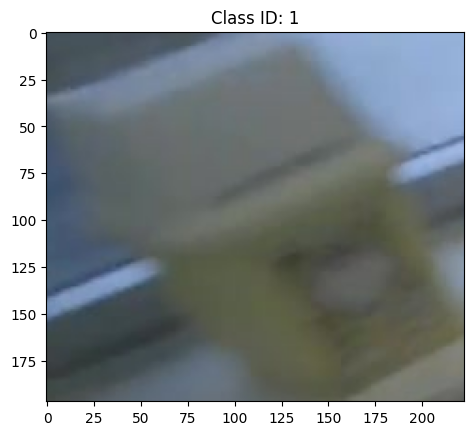

In [ ]:
dinov2 = generate_embeddings.load_model()

SAME_BACKGROUND_INDEXES_PATH = Path("data/vector_indexes/same_background")
DIFF_BACKGROUND_INDEXES_PATH = Path("data/vector_indexes/diff_background")
if SAME_BACKGROUND_INDEXES_PATH.exists():
    shutil.rmtree(SAME_BACKGROUND_INDEXES_PATH)
if DIFF_BACKGROUND_INDEXES_PATH.exists():
    shutil.rmtree(DIFF_BACKGROUND_INDEXES_PATH)
SAME_BACKGROUND_INDEXES_PATH.mkdir(parents=True, exist_ok=True)
DIFF_BACKGROUND_INDEXES_PATH.mkdir(parents=True, exist_ok=True)

LABELING_SAME_BACKGROUND_UUID = "d6fd0aed-b901-4863-bad8-7910dad693e0"
LABELING_DIFF_BACKGROUND_UUID = "73ce8a30-ccc6-4514-b978-f8b5844be16b"
same_background_calibration_id = recording_uuid_to_calibration_id(LABELING_SAME_BACKGROUND_UUID)
diff_background_calibration_id = recording_uuid_to_calibration_id(LABELING_DIFF_BACKGROUND_UUID)

# Check what the minimum number of samples per class is:
annotated_classes = get_annotated_classes(same_background_calibration_id)

min_samples_per_class = 100000000000
for anno_class in annotated_classes:
    if len(anno_class.annotation_paths) < min_samples_per_class:
        min_samples_per_class = len(anno_class.annotation_paths)
print(f"Minimum samples per class: {min_samples_per_class}")

samples_per_class = [100, 200, 300, 400, 500, 600, min_samples_per_class]

def create_vector_indexes(dinov2, calibration_id: int, vector_indexes_path: Path):
    for samples in samples_per_class:
        output_path = vector_indexes_path / f"{samples}_samples_per_class.index"
        create_vector_index(dinov2, calibration_id, samples, output_path)
    
create_vector_indexes(dinov2, same_background_calibration_id, SAME_BACKGROUND_INDEXES_PATH)
# create_vector_indexes(dinov2, diff_background_calibration_id, DIFF_BACKGROUND_INDEXES_PATH)